In [13]:
from ilastik_profiler import utils
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from skimage import exposure
import numpy as np
from skimage import measure

In [14]:
channels = ["Brightfield", "ER", "AGP", "Mito", "DNA", "RNA"]

path_dir_seg_cprof = "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/test-set/cell-profiler-segmentation/"
path_dir_seg_ilastik = "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/test-set/hdf5s/"
path_dir_seg_cpose = "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/test-set/tifs-2channel"

tag_gt = "gt"
tag_seg_cprof = "_label_nuc.tiff"
tag_seg_ilastik = "Segmentation"
tag_seg_cpose = "_seg"

path_dir_im = "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/test-set/tifs"
path_dir_gt = "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/test-set/hdf5s/"

path_cp_stats_nuc = "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/test-set/test_setNuclei.csv"
path_cp_stats_cell = "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/test-set/test_setCells.csv"

cp_stat_limits = {"AreaShape_Area": (300, 4000), "Neighbors_NumberOfNeighbors_Adjacent": (-1, 5), "Neighbors_PercentTouching_Adjacent":(-1, 50)}
reg_stat_limits = {"area": (-1, 4000)}

kwargs = {"path_cp_stats_nuc":path_cp_stats_nuc, "path_cp_stats_cell":path_cp_stats_cell, "cp_stat_limits":cp_stat_limits}

# View results

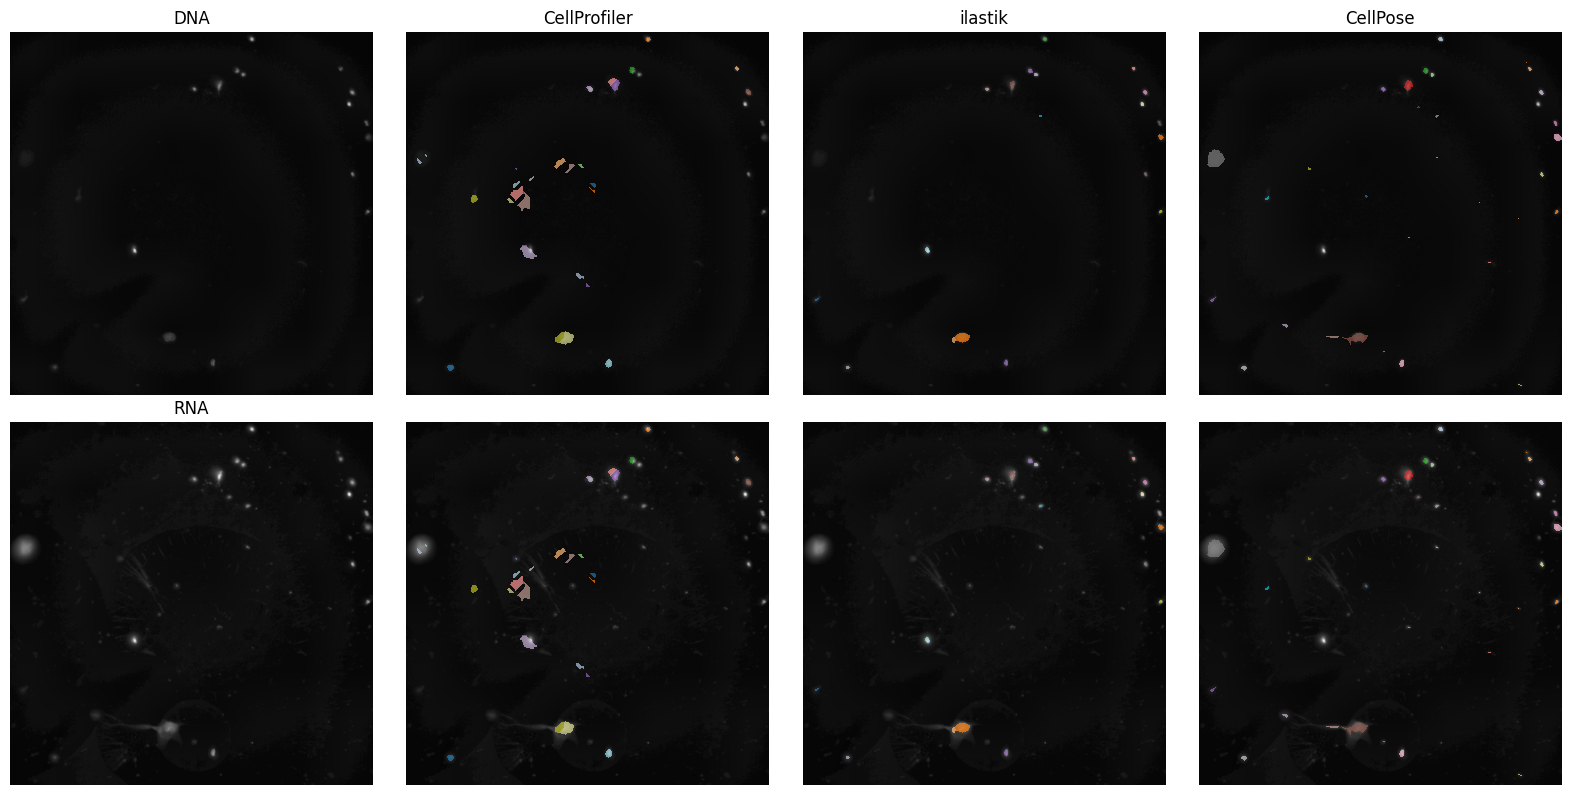

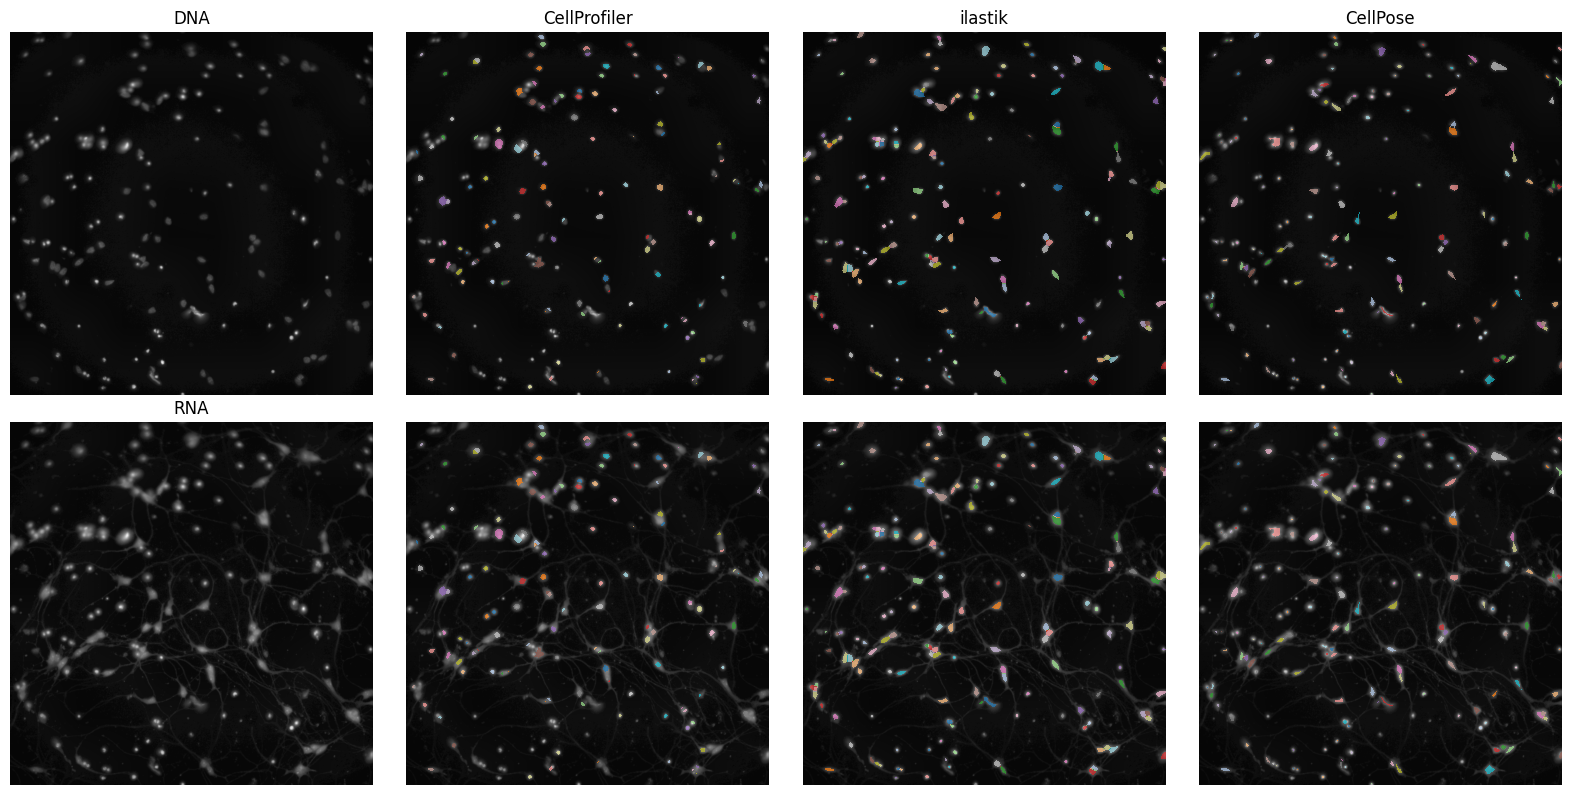

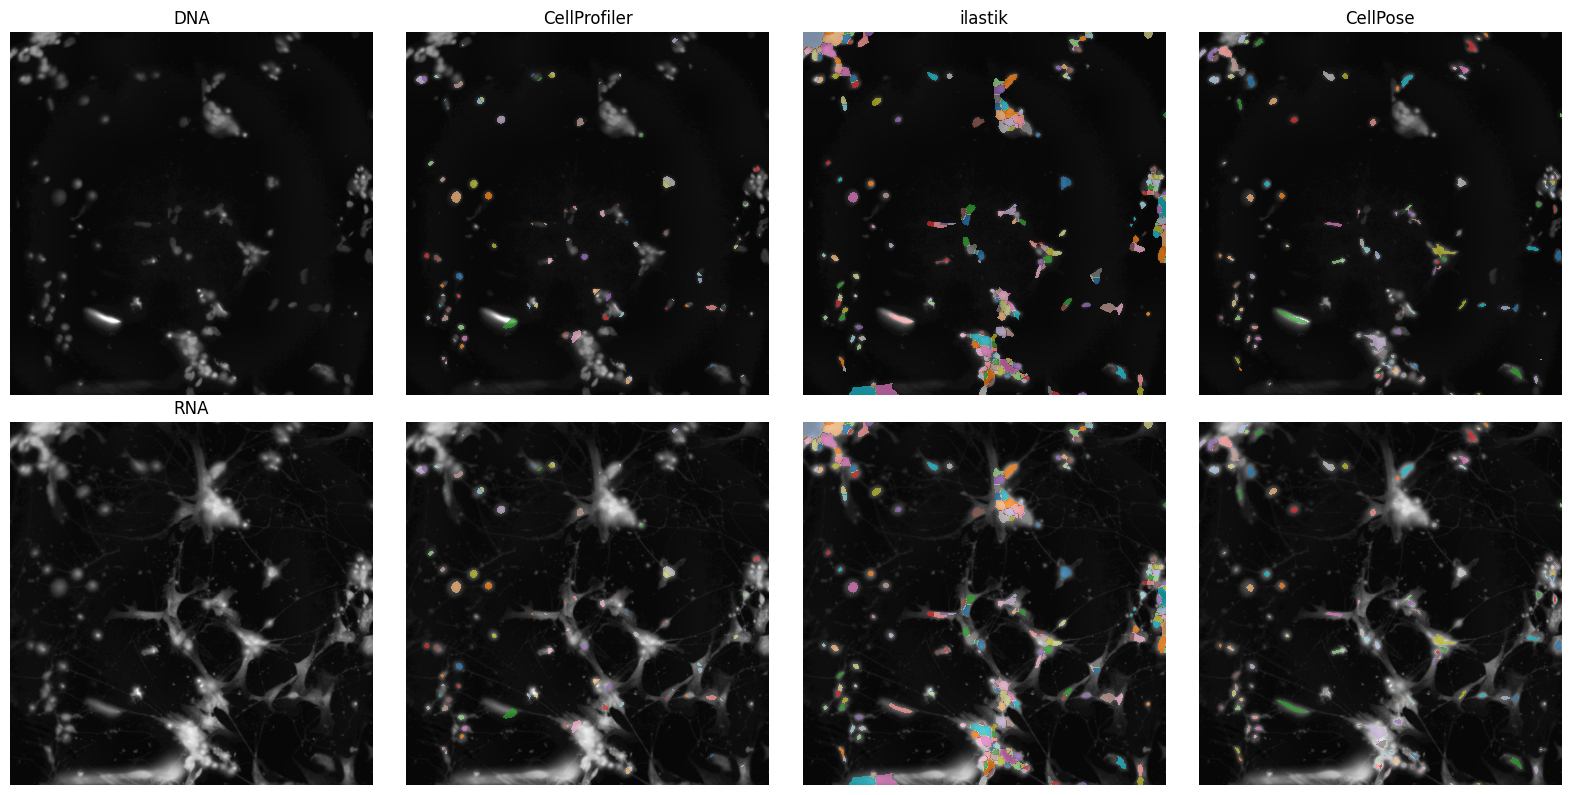

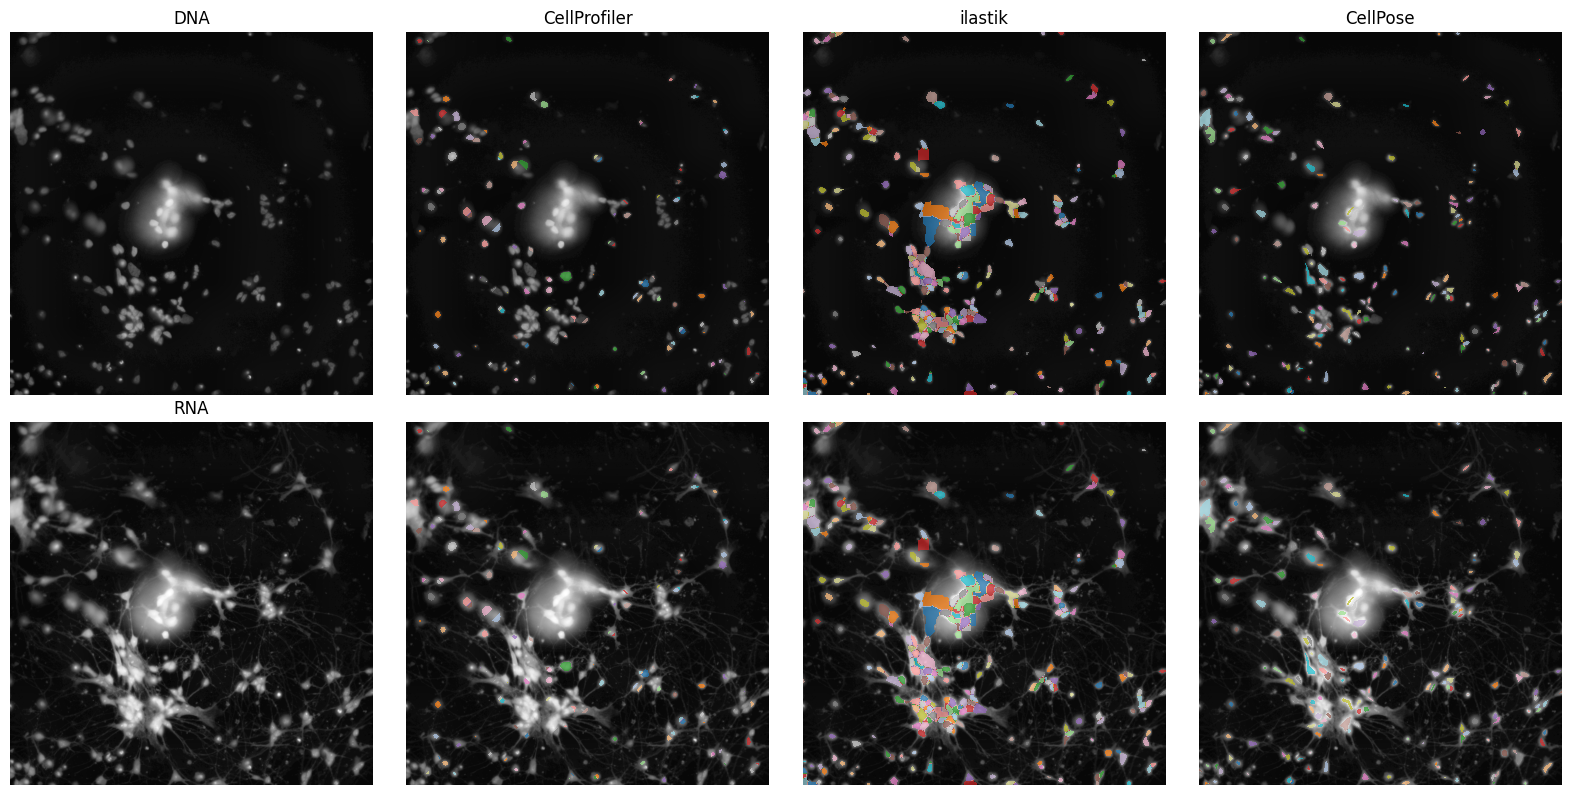

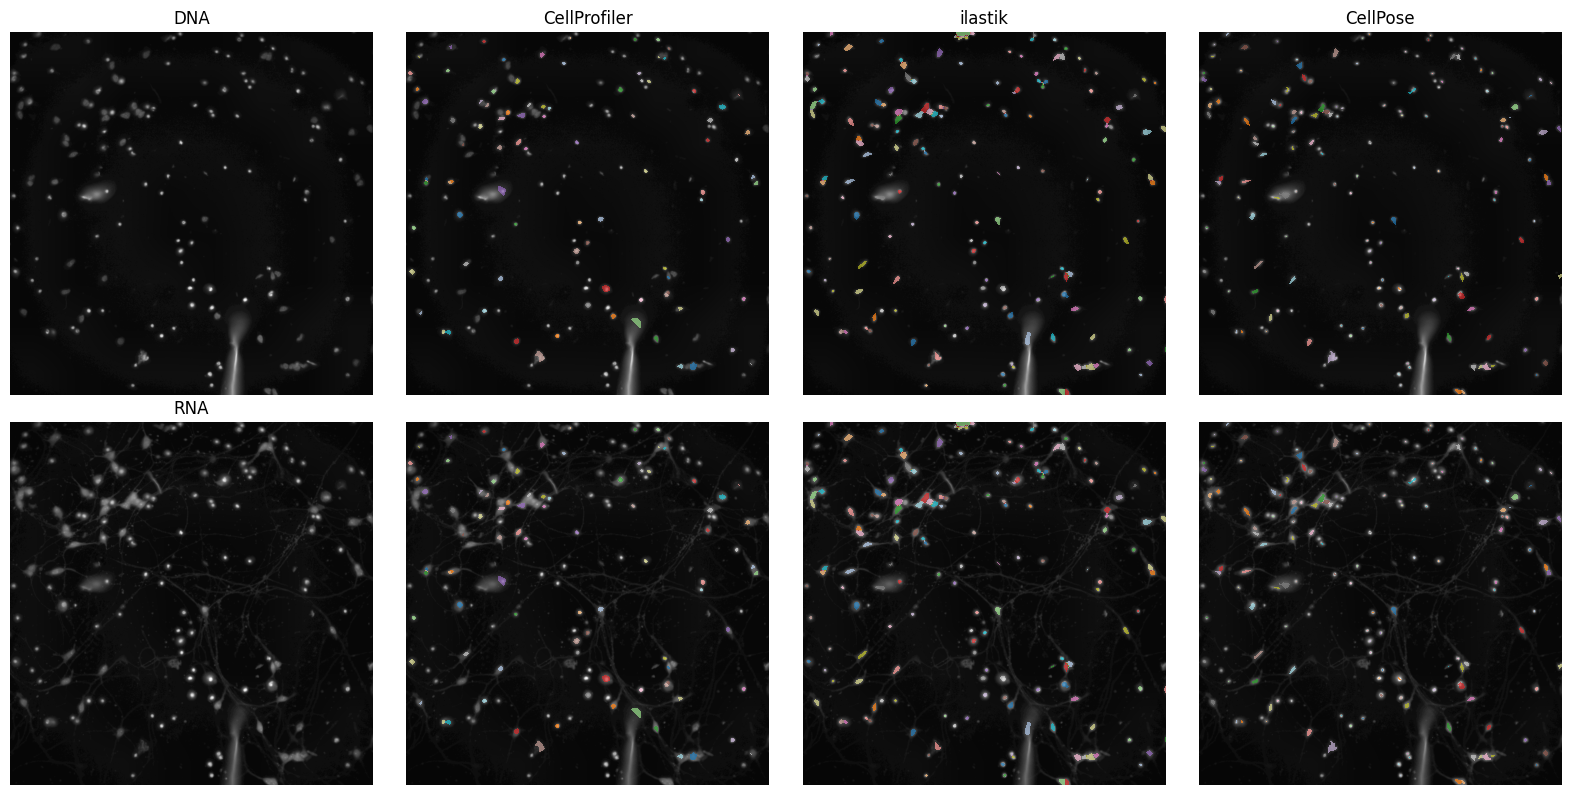

In [20]:
id_to_path_im = utils.get_id_to_path(path_dir_im)
id_to_path_gt = utils.get_id_to_path(path_dir_gt, tag_gt)
id_to_path_seg_cprof = utils.get_id_to_path(path_dir_seg_cprof, tag_seg_cprof)
id_to_path_seg_ilastik = utils.get_id_to_path(path_dir_seg_ilastik, tag_seg_ilastik)
id_to_path_seg_cpose = utils.get_id_to_path(path_dir_seg_cpose, tag_seg_cpose)

for id in id_to_path_gt.keys():
    images = utils.read_ims(id_to_path_im[id])

    seg_pred_cprof = utils.read_seg(id_to_path_seg_cprof[id])
    regions = utils.cp_filter(id, measure.regionprops(seg_pred_cprof), **kwargs)
    seg_pred_cprof_filtered = np.zeros_like(seg_pred_cprof)
    for region in regions:
        seg_pred_cprof_filtered[seg_pred_cprof == region.label] = region.label

    seg_pred_ilastik = utils.read_seg(id_to_path_seg_ilastik[id])
    regions = utils.reg_prop_filter(measure.regionprops(seg_pred_ilastik), reg_stat_limits)
    seg_pred_ilastik_filtered = np.zeros_like(seg_pred_ilastik)
    for region in regions:
        seg_pred_ilastik_filtered[seg_pred_ilastik == region.label] = region.label

    seg_pred_cpose = utils.read_seg(id_to_path_seg_cpose[id])
    regions = utils.reg_prop_filter(measure.regionprops(seg_pred_cpose), reg_stat_limits)
    seg_pred_cpose_filtered = np.zeros_like(seg_pred_cpose)
    for region in regions:
        seg_pred_cpose_filtered[seg_pred_cpose == region.label] = region.label

    seg_gt = utils.read_seg(id_to_path_gt[id])


    image_dna = images[channels.index("DNA")]
    image_dna = exposure.equalize_adapthist(image_dna, clip_limit=0.03)
    image_rna = images[channels.index("RNA")]
    image_rna = exposure.equalize_adapthist(image_rna, clip_limit=0.03)

    f, axs = plt.subplots(nrows=2, ncols=4)
    for ax_col, seg in zip(axs.T, [np.zeros_like(image_dna), seg_pred_cprof_filtered, seg_pred_ilastik_filtered, seg_pred_cpose_filtered]):
        seg_masked = np.ma.masked_array(seg, mask=seg == 0)

        ax_col[0].imshow(image_dna, cmap="gray")
        ax_col[0].imshow(seg_masked % 20, cmap="tab20", alpha=0.7)
        ax_col[0].axis("off")

        ax_col[1].imshow(image_rna, cmap="gray")
        ax_col[1].imshow(seg_masked % 20, cmap="tab20", alpha=0.7)
        ax_col[1].axis("off")

    for ax_col, name in zip(axs.T, ["DNA", "CellProfiler", "ilastik", "CellPose"]):
        ax_col[0].set_title(name)

    axs[1,0].set_title("RNA")
    f.set_size_inches(16, 8)
    f.tight_layout()
    plt.savefig(f"./{id}.svg")

# False negatives

In [4]:
df_fn_cp = utils.get_fn_rates(path_dir_gt=path_dir_gt, path_dir_seg=path_dir_seg_cprof, tag_gt=tag_gt, tag_seg=tag_seg_cprof, **kwargs)
df_fn_cp["Method"] = "CellProfiler"

df_fn_ilastik = utils.get_fn_rates(path_dir_gt=path_dir_gt, path_dir_seg=path_dir_seg_ilastik, tag_gt=tag_gt, tag_seg=tag_seg_ilastik, reg_stat_limits=reg_stat_limits)
df_fn_ilastik["Method"] = "ilastik"

df_fn_cpose = utils.get_fn_rates(path_dir_gt=path_dir_gt, path_dir_seg=path_dir_seg_cpose, tag_gt=tag_gt, tag_seg=tag_seg_cpose, reg_stat_limits=reg_stat_limits)
df_fn_cpose["Method"] = "CellPose"

df_fn_combined = pd.concat((df_fn_cp, df_fn_ilastik, df_fn_cpose))

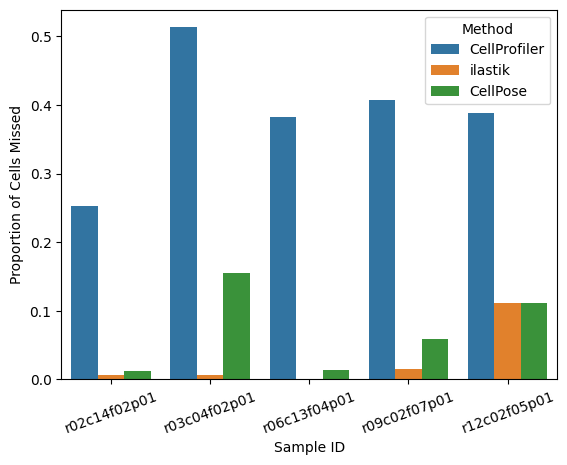

In [5]:
sns.barplot(df_fn_combined, x="Sample ID", y="Proportion of Cells Missed", hue="Method") 
plt.xticks(rotation=20)
plt.savefig("./missed-cells.svg")

# Annotate predictions

In [3]:
path_dir_gt = "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/test-set/hdf5s/"
path_dir_seg_cpose = "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/test-set/tifs-2channel"
out_dir = "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/test-set/tifs-2channel"


tag_gt = "gt"
tag_seg_cpose = "_seg"

reg_stat_limits = {"area": (-1, 4000)}


0/37


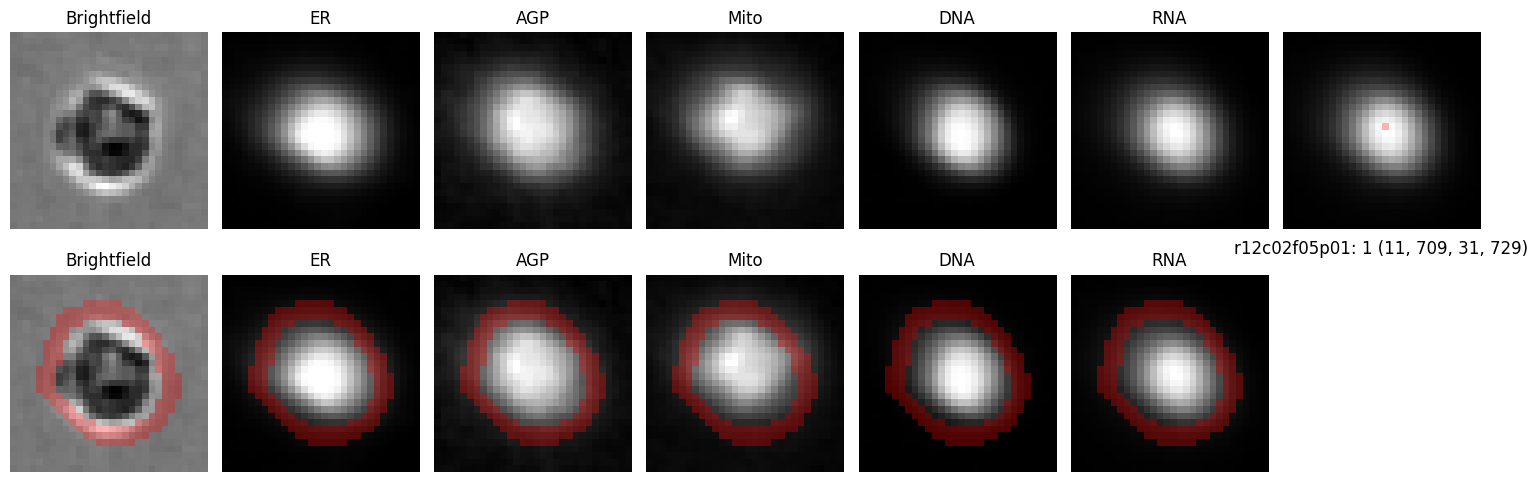

0/165


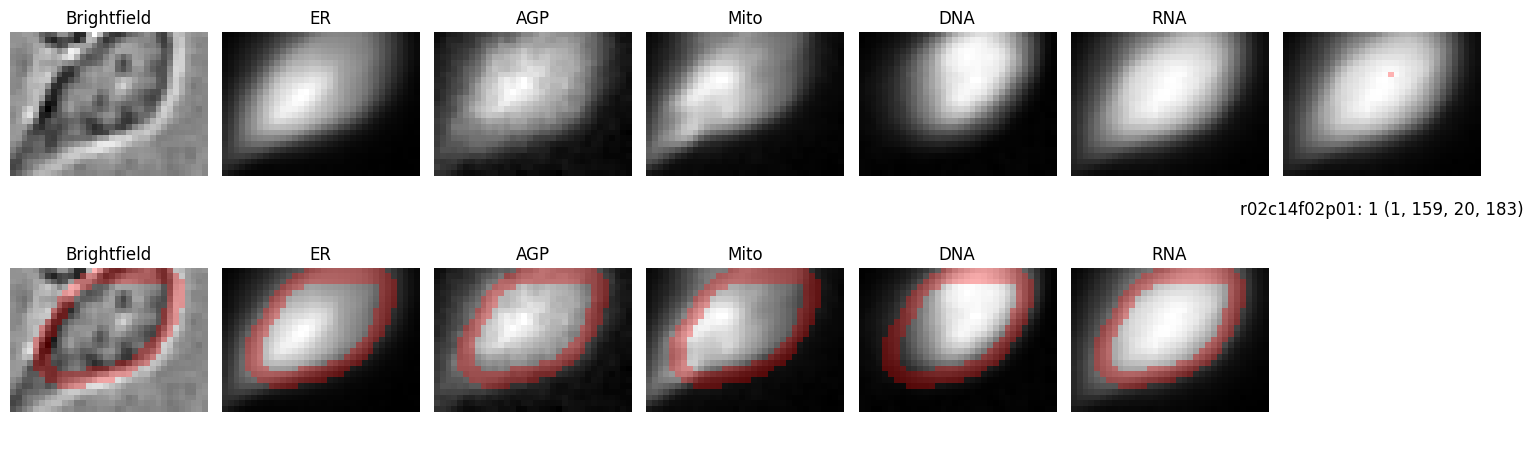

0/116


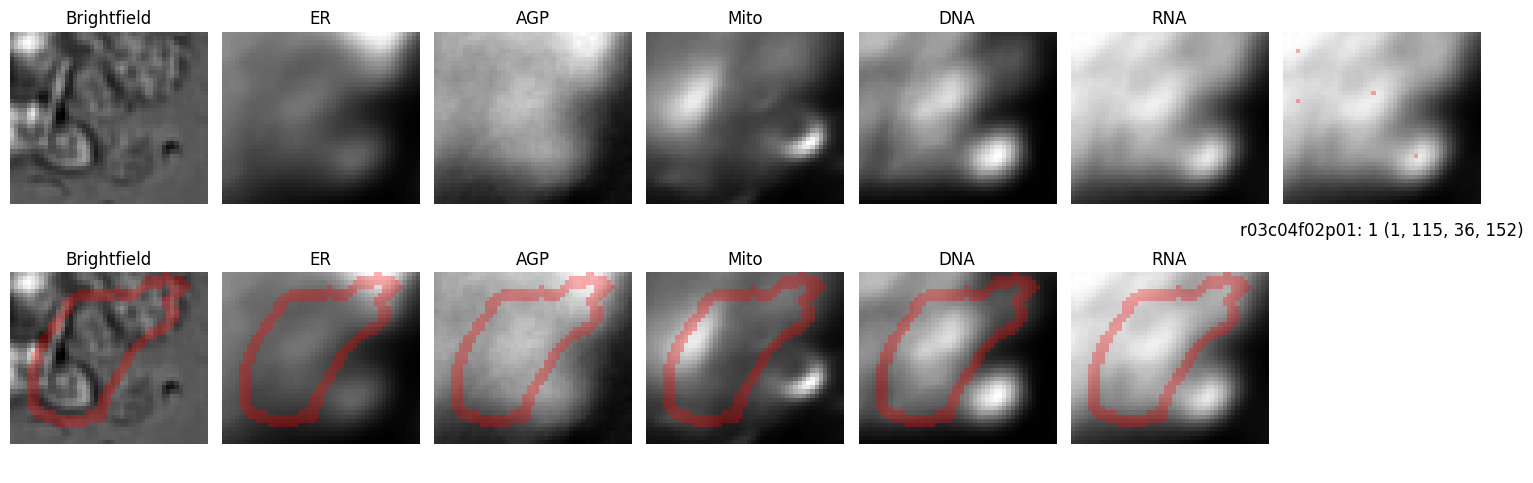

0/187


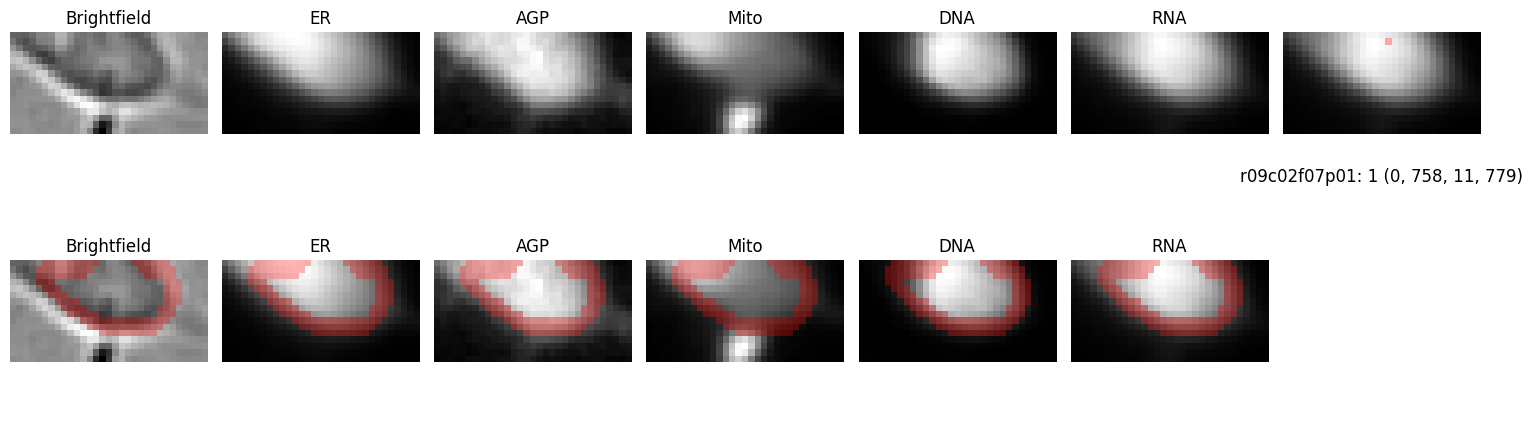

0/163


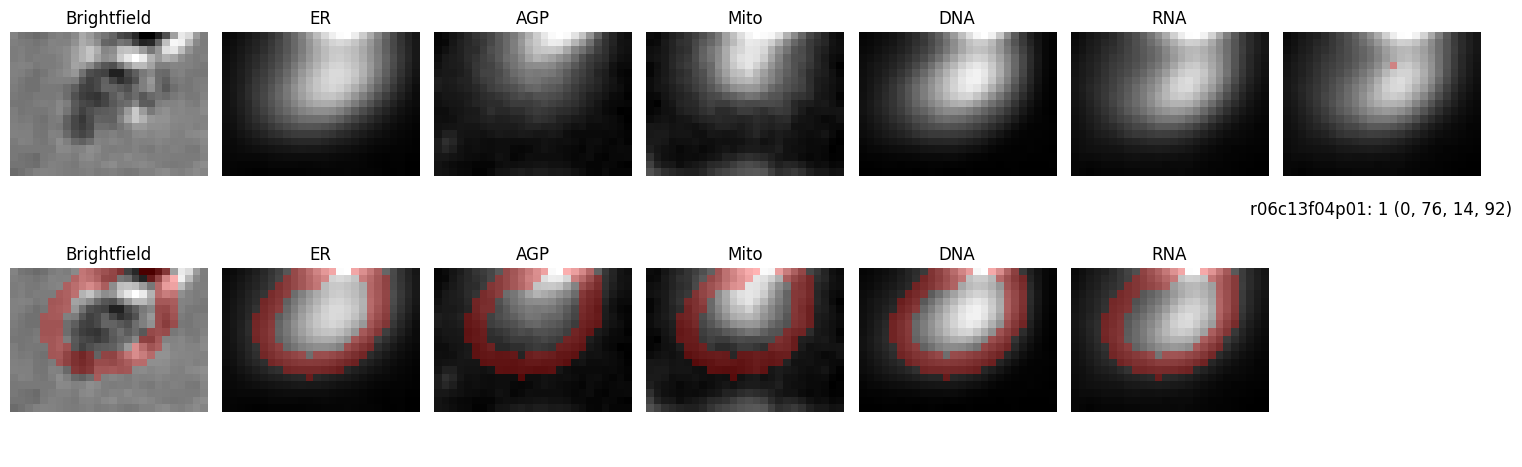

In [4]:
utils.eval_detections(path_dir_im=path_dir_im, channels=channels, path_dir_gt=path_dir_gt, path_dir_seg=path_dir_seg_cpose, out_dir=out_dir, tag_gt=tag_gt, tag_seg=tag_seg_cpose, reg_stat_limits=reg_stat_limits)

# Detection Type

In [10]:
path_dettype_ilastik = "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/all_data_ilastik.pickle"
path_dettype_cprof = "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/all_data.pickle"
path_dettype_cpose = "/Users/thomasathey/Documents/shavit-lab/fraenkel/first-sample/Assay Dev 20230329/BR00142688__2024-03-29T19_57_13-Measurement 1/test-set/tifs-2channel/all_data.pickle"


In [11]:
df_cprof = utils.get_detection_types(path_dettype_cprof)
df_cprof["Method"] = "CellProfiler"

df_ilastik = utils.get_detection_types(path_dettype_ilastik)
df_ilastik["Method"] = "ilastik"

df_cpose = utils.get_detection_types(path_dettype_cpose)
df_cpose["Method"] = "CellPose"

df_combined = pd.concat((df_cprof, df_ilastik, df_cpose))

Text(0.5, 1.0, 'Types of detections')

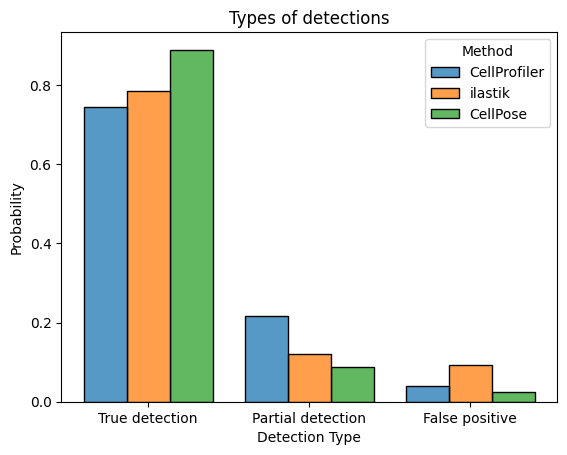

In [12]:
sns.histplot(df_combined, x="Detection Type", weights="count", hue="Method", multiple="dodge", stat="probability", common_norm=False, shrink=0.8)
plt.title(f"Types of detections")

In [13]:
new_sampledid = []
for i, row in df_combined.iterrows():
    new_sampledid.append(row["Sample ID"].split(" ")[0])

df_combined["Sample ID"] = new_sampledid
df_combined = df_combined.sort_values(by = ["Sample ID"])

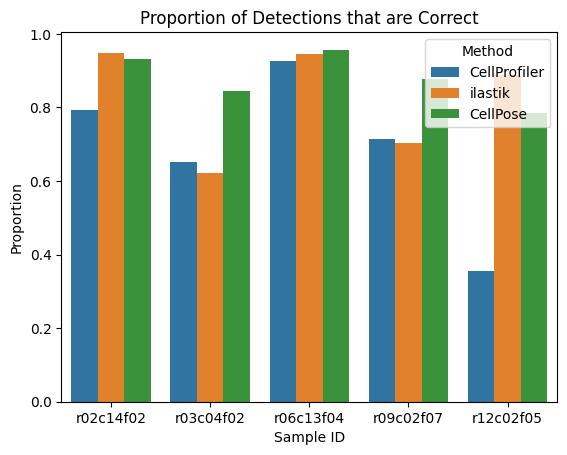

In [21]:

sns.barplot(df_combined[df_combined["Detection Type"] == "True detection"], x="Sample ID", y="Proportion", hue="Method")
plt.title("Proportion of Detections that are Correct")
plt.savefig("./det-types.svg")